In [3]:
!pip install -q transformers

In [4]:
!pip install -q datasets jiwer

In [6]:
import pandas as pd
import os

# Path to the folders
images_folder = '/kaggle/input/00000000000/OUTPUT/images'
labels_folder = '/kaggle/input/00000000000/OUTPUT/labels'

# List to store image paths and labels
data = []

# Iterate over files in images folder
for image_file in os.listdir(images_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        # Get image path
        image_path = os.path.join(images_folder, image_file)
        
        # Get corresponding label
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        if os.path.exists(label_path):
           with open(label_path, 'r', encoding='utf-8') as f:  # Use UTF-8 encoding
                    label = f.read().strip()
        else:
            label = None
        
        # Add image path and label to data list
        data.append({'image_path': image_path, 'label': label})

# Create DataFrame from the data list
df = pd.DataFrame(data)
df.head()

,image_path,label
0,/kaggle/input/00000000000/OUTPUT/images/img (6...,محمد نجيب مرعي
1,/kaggle/input/00000000000/OUTPUT/images/img (5...,محمود\nحلمي السيد ابوزيد
2,/kaggle/input/00000000000/OUTPUT/images/img (5...,محمد\nامين نجيب مرعي
3,/kaggle/input/00000000000/OUTPUT/images/img (8...,يونان\nناجي يونان مسعود
4,/kaggle/input/00000000000/OUTPUT/images/img (1...,محمد\nصلاح موسي عبدالله شرف


In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=47):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['image_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [9]:
from transformers import TrOCRProcessor
from transformers import AutoTokenizer
from transformers import VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

tokenizer2 = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
processor.tokenizer = tokenizer2

#model defining
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
train_dataset = Dataset(root_dir='',
                           df=train_df,
                           processor=processor)
eval_dataset = Dataset(root_dir='',
                           df=test_df,
                           processor=processor)

2025-03-17 21:18:59.313243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 21:18:59.313369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 21:18:59.457245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 54
Number of validation examples: 7


In [11]:
# max_label_size = 0
# # Iterate over all indices in eval_dataset
# for idx in range(len(train_dataset)):
#     encoding = train_dataset[idx]
#     for k, v in encoding.items():
#         if k == 'labels' and v.shape[0] > max_label_size:
#             max_label_size = v.shape[0]
#             max_label_idx = idx

# for idx in range(len(eval_dataset)):
#     encoding = eval_dataset[idx]
#     for k, v in encoding.items():
#         if k == 'labels' and v.shape[0] > max_label_size:
#             max_label_size = v.shape[0]
#             max_label_idx = idx

# if max_label_idx is not None:
#     print(f"Maximum label size found at index {max_label_idx}, with size {max_label_size}.")
# else:
#     print("No 'labels' key found in eval_dataset.")


In [12]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([47])


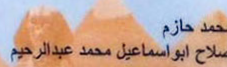

In [13]:
image = Image.open(train_dataset.root_dir + train_df['image_path'][0]).convert("RGB")
image

In [14]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)
print(labels)

محمد حازم صلاح ابواسماعيل محمد عبدالرحيم
tensor([   33,   534,  6483,  3295, 14472,  1020, 12976,   534, 11143,    34,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31])


In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=16)

In [16]:
# from transformers import VisionEncoderDecoderModel
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
# model.to(device)
# model.summary

In [17]:
import torch.nn as nn
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

#model.config.vocab_size = model.config.decoder.vocab_size

model.decoder.config.vocab_size = processor.tokenizer.vocab_size
model.config.vocab_size = model.config.decoder.vocab_size
model.decoder.output_projection = nn.Linear(256, processor.tokenizer.vocab_size)
model.decoder.model.decoder.embed_tokens = nn.Embedding(processor.tokenizer.vocab_size, 256, padding_idx=1)


# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 47
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 8

In [18]:
from datasets import load_metric

cer_metric = load_metric("cer")
wer_metric = load_metric("wer")

/tmp/ipykernel_34/782987868.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [19]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

def compute_wer(pred_ids, label_ids):
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [25]:
from transformers import AdamW
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import LambdaLR

train_loss_list = []
CER_list = []
WER_list = []
optimizer = AdamW(model.parameters(), lr=5e-5,no_deprecation_warning=True)
print("Learning rate =", optimizer.param_groups[0]['lr'])


for epoch in range(100):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss_list.append(train_loss/len(train_dataloader))
    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    print("Learning rate =", optimizer.param_groups[0]['lr'])

    # evaluate
    model.eval()
    valid_cer = 0.0
    valid_wer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer 
            valid_wer += wer
    CER_list.append(valid_cer / len(eval_dataloader))
    WER_list.append(valid_wer / len(eval_dataloader))
    print("Validation CER:", valid_cer / len(eval_dataloader))
    print("Validation WER:", valid_wer / len(eval_dataloader))

model.save_pretrained(".")

Learning rate = 5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 0: 6.486045718193054
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6914285714285714
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 1: 6.242949962615967
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.84
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 2: 6.138822555541992
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7371428571428571
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 3: 6.0845654010772705
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.8
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 4: 5.654978513717651
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6857142857142857
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 5: 5.658414840698242
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.9885714285714285
Validation WER: 1.3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 6: 5.379405856132507
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.04
Validation WER: 1.3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 7: 5.104432821273804
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.2114285714285715
Validation WER: 1.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 8: 5.003286719322205
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.8628571428571429
Validation WER: 1.1666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 9: 4.8720598220825195
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.7142857142857142
Validation WER: 2.2333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 10: 4.540409803390503
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.1485714285714286
Validation WER: 1.5666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 11: 4.312487781047821
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.1142857142857143
Validation WER: 1.4666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 12: 4.198598742485046
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6914285714285714
Validation WER: 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 13: 4.102021276950836
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.2114285714285715
Validation WER: 1.7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 14: 3.774098753929138
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.8171428571428572
Validation WER: 1.1666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 15: 3.4316758513450623
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.8285714285714286
Validation WER: 1.1333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 16: 3.4956332445144653
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.1028571428571428
Validation WER: 1.5666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 17: 3.405118227005005
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6457142857142857
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 18: 3.08277028799057
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.9371428571428572
Validation WER: 1.2333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 19: 3.1256502866744995
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6514285714285715
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 20: 2.915939688682556
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.9828571428571429
Validation WER: 1.3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 21: 2.8490817546844482
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7657142857142857
Validation WER: 0.9666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 22: 2.6910337805747986
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 1.0114285714285713
Validation WER: 1.3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 23: 2.4891620874404907
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.68
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 24: 2.3789345622062683
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.68
Validation WER: 0.9333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 25: 2.207880586385727
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5657142857142857
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 26: 2.110229939222336
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6914285714285714
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 27: 2.0860927402973175
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6457142857142857
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 28: 1.9403171241283417
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.64
Validation WER: 0.7666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 29: 1.8606887459754944
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7542857142857143
Validation WER: 0.9666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 30: 1.7271654307842255
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6285714285714286
Validation WER: 0.7666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 31: 1.6198359727859497
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5885714285714285
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 32: 1.668066680431366
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6285714285714286
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 33: 1.5360412001609802
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6228571428571429
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 34: 1.4136179387569427
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6342857142857142
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 35: 1.36921226978302
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7142857142857143
Validation WER: 0.9666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 36: 1.249609649181366
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7028571428571428
Validation WER: 0.9666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 37: 1.1131824254989624
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.8228571428571428
Validation WER: 1.1333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 38: 1.104866474866867
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.68
Validation WER: 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 39: 0.9916370362043381
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6457142857142857
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 40: 0.971390575170517
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7542857142857143
Validation WER: 1.0333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 41: 0.8936924785375595
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.56
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 42: 0.865294799208641
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7142857142857143
Validation WER: 0.9333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 43: 0.8452020585536957
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6685714285714286
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 44: 0.7712567299604416
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6628571428571428
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 45: 0.7204047590494156
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6457142857142857
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 46: 0.714946523308754
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5714285714285714
Validation WER: 0.7666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 47: 0.6516864895820618
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6342857142857142
Validation WER: 0.7666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 48: 0.6066811978816986
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6342857142857142
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 49: 0.5755779594182968
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6
Validation WER: 0.7666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 50: 0.5242908969521523
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5314285714285715
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 51: 0.511927142739296
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6171428571428571
Validation WER: 0.7666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 52: 0.5015749633312225
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5542857142857143
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 53: 0.46756842732429504
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.7028571428571428
Validation WER: 0.9333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 54: 0.47187238931655884
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5314285714285715
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 55: 0.5026361867785454
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.56
Validation WER: 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 56: 0.5300906449556351
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5142857142857142
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 57: 0.5517796874046326
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6114285714285714
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 58: 0.48159584403038025
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6057142857142858
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 59: 0.4993078485131264
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5142857142857142
Validation WER: 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 60: 0.5151248723268509
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5485714285714286
Validation WER: 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 61: 0.4443900063633919
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.45714285714285713
Validation WER: 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 62: 0.4497870206832886
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6228571428571429
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 63: 0.4257717803120613
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 64: 0.4333505854010582
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5314285714285715
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 65: 0.4003792926669121
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5314285714285715
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 66: 0.42202505469322205
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5142857142857142
Validation WER: 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 67: 0.3831927329301834
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6628571428571428
Validation WER: 0.8666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 68: 0.41007085144519806
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5714285714285714
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 69: 0.3904964029788971
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.4685714285714286
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 70: 0.3550190106034279
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5485714285714286
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 71: 0.3590110316872597
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5142857142857142
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 72: 0.37747734785079956
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6057142857142858
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 73: 0.32233715802431107
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6514285714285715
Validation WER: 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 74: 0.32715705037117004
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5028571428571429
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 75: 0.3304894492030144
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5257142857142857
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 76: 0.31516773998737335
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.48
Validation WER: 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 77: 0.3276885449886322
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5542857142857143
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 78: 0.34091658890247345
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5428571428571428
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 79: 0.3212118521332741
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5828571428571429
Validation WER: 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 80: 0.33927785605192184
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6628571428571428
Validation WER: 0.8333333333333334


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 81: 0.32977668195962906
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5657142857142857
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 82: 0.33092691749334335
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.6171428571428571
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 83: 0.33784014731645584
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5828571428571429
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 84: 0.30025529861450195
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5828571428571429
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 85: 0.2964002341032028
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.4742857142857143
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 86: 0.31748076528310776
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5371428571428571
Validation WER: 0.7333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 87: 0.32127565145492554
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.52
Validation WER: 0.7666666666666667


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 88: 0.2997412830591202
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.44571428571428573
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 89: 0.2939813509583473
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5085714285714286
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 90: 0.2913099564611912
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.48
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 91: 0.311926506459713
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.48
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 92: 0.29937605559825897
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5028571428571429
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 93: 0.2918558791279793
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.4857142857142857
Validation WER: 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 94: 0.3077531084418297
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.46285714285714286
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 95: 0.2874176427721977
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.4685714285714286
Validation WER: 0.6666666666666666


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 96: 0.3007693514227867
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.5828571428571429
Validation WER: 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 97: 0.28859933838248253
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.49142857142857144
Validation WER: 0.6333333333333333


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 98: 0.31864606589078903
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation CER: 0.4742857142857143
Validation WER: 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

Loss after epoch 99: 0.31461895257234573
Learning rate = 5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 47, 'early_stopping': True, 'num_beams': 8, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.5085714285714286
Validation WER: 0.6333333333333333


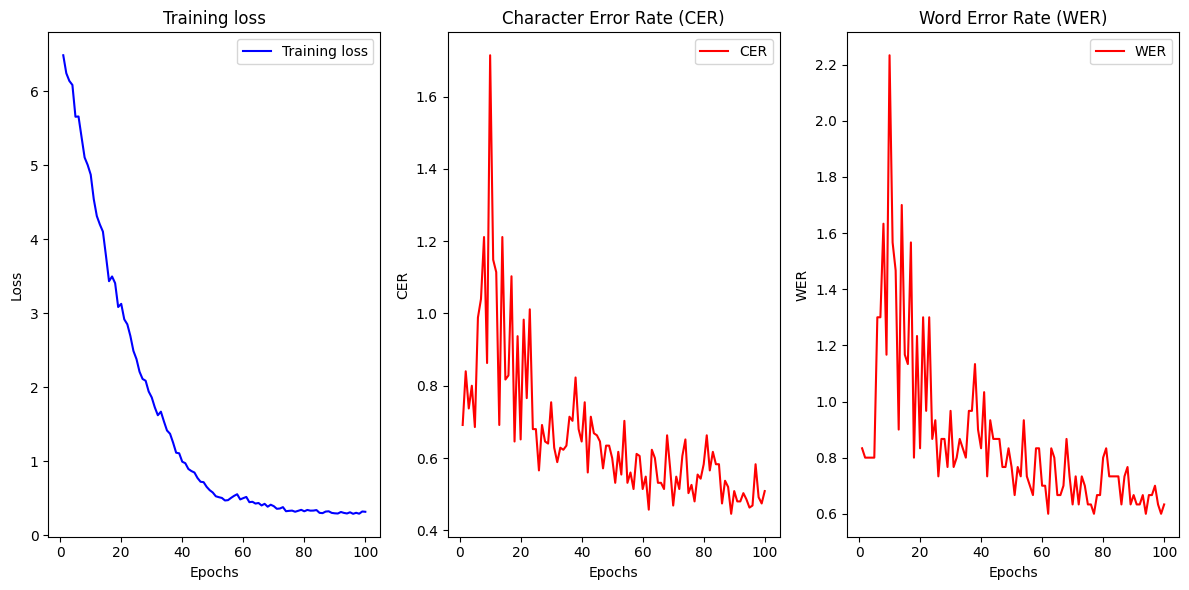

In [26]:
import matplotlib.pyplot as plt

# Assuming loss and CER contain values for each epoch
epochs = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, CER_list, 'r', label='CER')
plt.title('Character Error Rate (CER)')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, WER_list, 'r', label='WER')
plt.title('Word Error Rate (WER)')
plt.xlabel('Epochs')
plt.ylabel('WER')
plt.legend()

plt.tight_layout()
plt.show()

Label: اماني
حسن السباعي محمد
Generated: محمد امين نجيب مرعي


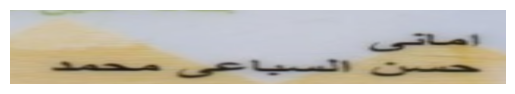

Label: كرم
عبدالتواب منصور ابراهيم
Generated: محمد مبروك امين السيد قنديل


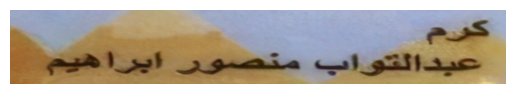

Label: محمد
صلاح موسي عبدالله شرف
Generated: محمد مبروك حافظ قنديل


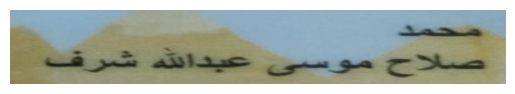

Label: محمد
امين نجيب مرعي
Generated: محمد امين نجيب مرعي


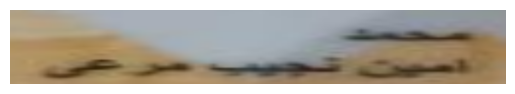

Label: محمد
عبدالخالق عبدالهادي شلبي
Generated: لمعي محمد السيد قنديل فلو


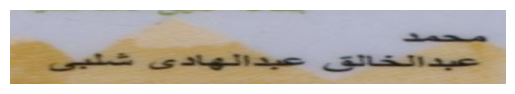

Label: احمد
ابراهيم محمد الخولي
Generated: محمد احمد مجاهد


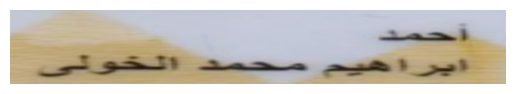

Label: محمود
فتحي اسماعيل محمد امين
Generated: محمد امين نجيب مرعي


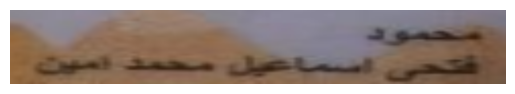

In [27]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os

# Ensure test_df and device are defined before running this script
# test_df = pd.read_csv("your_test_data.csv")  # Example loading
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the display function
def display_image_with_text(image_path, label, text, size=(300, 2000)):
    image = plt.imread(image_path)

    # Convert float images (matplotlib loads some formats as float)
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image_tensor = transform(image)

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image_np)
    print("Label: " + label)
    print("Generated: " + text)
    plt.axis('off')
    plt.show()


# Generate predictions for the test set
for index, row in test_df.head(20).iterrows():
    # Load the image
    image_path = row['image_path']
    original_label = row['label']

    # Load the image and convert it if needed
    image = plt.imread(image_path)
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((384, 384)),
        transforms.ToTensor()
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate prediction
    with torch.no_grad():  # Disable gradient calculations for inference
        outputs = model.generate(image_tensor)

    # Decode output properly
    predicted_text = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Display the image with original and predicted text
    display_image_with_text(image_path, original_label, predicted_text)
